https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html#Weight-pruning

# Datos stock MXN_DLL

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from finta import TA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from scipy.special import expit

In [2]:
data=yf.Ticker('MXN=X')
data=data.history(period="max")
data=data.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
data.tail()

,Open,High,Low,Close
Date,,,,
2020-09-29,22.3654,22.5348,22.1852,22.3491
2020-09-30,22.3792,22.5253,22.0493,22.3735
2020-10-01,22.0745,22.1092,21.7896,22.0816
2020-10-02,21.8468,22.0578,21.6533,21.8447
2020-10-05,21.5972,21.6132,21.3006,21.5950


In [3]:
sp=yf.Ticker('SPY')
sp=sp.history(period="max")
sp=sp.loc["2000-01-20":"2020-12-31"][["Open","High","Low",'Close']]
sp.tail()

,Open,High,Low,Close
Date,,,,
2020-09-29,333.97,334.77,331.62,332.37
2020-09-30,333.09,338.29,332.88,334.89
2020-10-01,337.69,338.74,335.01,337.04
2020-10-02,331.70,337.01,331.19,333.84
2020-10-05,336.06,339.95,336.01,339.76


In [4]:
data=data.join(sp,how="left",rsuffix="sp")

In [5]:
data["sp_percent_change"] = data["Closesp"].pct_change(periods=1).astype(float)
#data = data.merge(SP["sp_percent_change"], left_index=True, right_index=True,how="left")
data["percent_change"] = data["Close"].pct_change(periods=1).astype(float)
# Daily percent change as compared to the S&P 500
data["relative_change"] = data["percent_change"] - data["sp_percent_change"]
data.tail()

,Open,High,Low,Close,Opensp,Highsp,Lowsp,Closesp,sp_percent_change,percent_change,relative_change
Date,,,,,,,,,,,
2020-09-29,22.3654,22.5348,22.1852,22.3491,333.97,334.77,331.62,332.37,-0.005446,0.001780,0.007226
2020-09-30,22.3792,22.5253,22.0493,22.3735,333.09,338.29,332.88,334.89,0.007582,0.001092,-0.006490
2020-10-01,22.0745,22.1092,21.7896,22.0816,337.69,338.74,335.01,337.04,0.006420,-0.013047,-0.019467
2020-10-02,21.8468,22.0578,21.6533,21.8447,331.70,337.01,331.19,333.84,-0.009494,-0.010728,-0.001234
2020-10-05,21.5972,21.6132,21.3006,21.5950,336.06,339.95,336.01,339.76,0.017733,-0.011431,-0.029164


In [6]:
data.columns=data.columns.str.lower()

In [7]:
def add_indicators(data):
        # This is a list of all possible indicators we can use
        # indicators = ['ADL', 'ADX', 'AO', 'APZ', 'ATR',
        # 'BASP', 'BASPN', 'BBANDS', 'BBWIDTH', 'CCI', 'CFI', 'CHAIKIN', 'CHANDELIER', 'CMO', 'COPP', 'DEMA', 'DMI',
        # 'DO', 'EBBP', 'EFI', 'EMA', 'EMV', 'ER', 'EVWMA', 'EV_MACD', 'FISH', 'FVE', 'HMA', 'ICHIMOKU', 'IFT_RSI',
        # 'KAMA', 'KC', 'KST', 'MACD', 'MFI', 'MI', 'MOM', 'MSD', 'OBV', 'PERCENT_B', 'PIVOT', 'PIVOT_FIB', 'PPO',
        # 'PZO', 'QSTICK', 'ROC', 'RSI', 'SAR', 'SMA', 'SMM', 'SMMA', 'SQZMI', 'SSMA', 'STC', 'STOCH', 'STOCHD',
        # 'STOCHRSI', 'TEMA', 'TMF', 'TP', 'TR', 'TRIMA', 'TRIX', 'TSI', 'UO', 'VAMA', 'VFI', 'VORTEX', 'VPT', 'VR',
        # 'VWAP', 'VW_MACD', 'VZO', 'WILLIAMS', 'WMA', 'WOBV', 'WTO', 'ZLEMA']

        # Here are all indicators we are using
    indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'ER', 'KAMA', 'ZLEMA',
                      'WMA', 'HMA', 'SMMA', 'MACD', 'PPO', 'MOM', 'ROC', 'RSI',
                      'IFT_RSI']
        # These indicators need more tuning or are broken
    broken_indicators = ['SAR', 'TMF', 'QSTICK']
    for indicator in indicators:
        if indicator not in broken_indicators:
            df = None
                # Using python's eval function to create a method from a string instead of having every method defined
            df = eval('TA.' + indicator + '(data)')
                # Some method return series, so we can check to convert here
            if not isinstance(df, pd.DataFrame):
                df = df.to_frame()
                # Appropriate labels on each column
            df = df.add_prefix(indicator + '_')
                # Join merge dataframes based on the date
            data = data.merge(df, left_index=True, right_index=True)
        # Fix labels
    data.columns = data.columns.str.replace(' ', '_')
    return(data)

In [8]:
data=add_indicators(data)

In [9]:
data.dropna(inplace=True)

In [10]:
data["dir"]=np.sign(data["percent_change"]).shift(-1)
data.dropna(inplace=True)
data["dir"]=data["dir"].apply(lambda x: 1 if x>=0 else 0)
data["dir_ant30"]=data["dir"].rolling(window=30).mean()
data.dropna(inplace=True)

In [11]:
data.tail(7)

,open,high,low,close,opensp,highsp,lowsp,closesp,sp_percent_change,percent_change,...,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,MOM_MOM,ROC_ROC,RSI_14_period_RSI,IFT_RSI_IFT_RSI,dir,dir_ant30
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-24,22.3936,22.6901,22.2702,22.3904,321.22,326.80,319.80,323.50,0.002666,0.033030,...,-0.219611,-0.559260,-1.013447,0.454187,1.0034,3.687101,63.747280,246.758585,0,0.466667
2020-09-25,22.1336,22.5272,21.9766,22.1384,322.58,329.58,321.64,328.73,0.016167,-0.011255,...,-0.188208,-0.288762,-0.868510,0.579748,0.7018,1.216145,58.289188,5.342111,1,0.500000
2020-09-28,22.3115,22.5675,22.1583,22.3094,333.22,334.96,332.15,334.19,0.016609,0.007724,...,-0.151059,-0.011335,-0.697075,0.685741,1.0419,4.312900,60.745316,0.245677,1,0.533333
2020-09-29,22.3654,22.5348,22.1852,22.3491,333.97,334.77,331.62,332.37,-0.005446,0.001780,...,-0.111278,0.219773,-0.513705,0.733479,1.2843,4.256738,61.314858,0.000361,1,0.533333
2020-09-30,22.3792,22.5253,22.0493,22.3735,333.09,338.29,332.88,334.89,0.007582,0.001092,...,-0.071291,0.406423,-0.329680,0.736103,1.2315,5.200423,61.682827,0.037618,0,0.533333
2020-10-01,22.0745,22.1092,21.7896,22.0816,337.69,338.74,335.01,337.04,0.006420,-0.013047,...,-0.037765,0.441236,-0.175497,0.616733,1.1024,4.827010,54.949081,0.052624,0,0.500000
2020-10-02,21.8468,22.0578,21.6533,21.8447,331.70,337.01,331.19,333.84,-0.009494,-0.010728,...,-0.013739,0.377205,-0.064956,0.442161,0.9520,3.323716,50.162884,0.028584,0,0.500000


In [12]:
X = data.drop('dir', axis=1).values
y = data['dir'].values

In [13]:
split=int(X.shape[0]*.8)
x_train,x_test,y_train,y_test=X[:split],X[split:],y[:split],y[split:]

In [14]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

# Definición del Modelo

## función de activación ReLu

In [15]:
def relu(X):
    return(np.maximum(X,np.zeros_like(X)))

## MLP Evaluación

Como en el esquema vamos a hacer una red con 2 capas ocultas + sus respectivas capas de inputs y outputs

In [16]:
num_inputs=X.shape[1]
num_outputs=to_categorical(y).shape[1]

In [17]:
def agunos(x):
    """
    Está función agrega el bias con una columna de 1's al principio
    
    input:
          array de mxn 
    output:
          array de (mx(n+1))
    """
    unos=np.ones((len(x),1))
    #print(unos.shape,x.shape)
    return np.concatenate([unos,x],axis=1)

Bayes NN


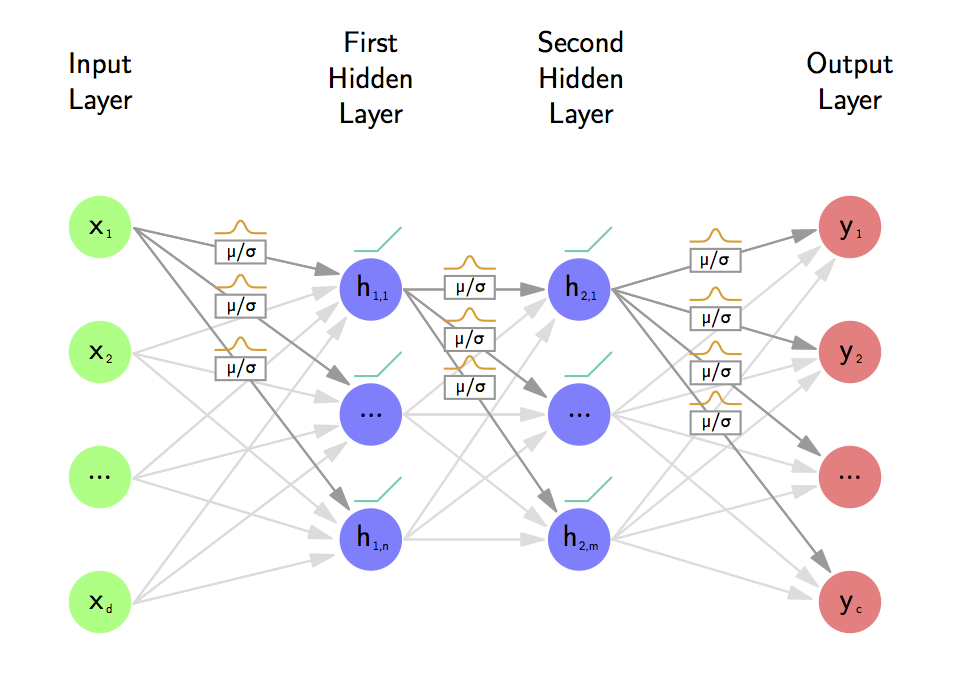

In [18]:
from IPython.display import Image
print("Bayes NN")
Image(filename='bbb_nn_bayes.png')

In [19]:
#número de capas ocultas
num_layers=2

# define function for evaluating MLP
def net(X, layer_params):
    """
    función que creo la aqrquitectura de la NN de arriba
    
    Input:
         X.- array mxn
         layer_params.- lista de arrays con los wi's o pesos  de cada etapa, los pares cson w's y nones biases
    Output:
         output: mx1 estimación 
    """
    H=[]
    layer_input = X
    for i in range(len(layer_params) // 2 - 1):
        #H=X@W+b
        h_linear = np.dot(layer_input, layer_params[2*i]) #+ layer_params[2*i + 1]
        H.append(h_linear)
        #ReLU(H)=RELU(X@W+b)
        layer_input = np.append(1,relu(h_linear))
    # last layer without ReLU
    output = np.dot(layer_input, layer_params[-2]) #+ layer_params[-1]
    return output,H

# define network weight shapes
layer_param_shapes = []
num_hidden = 400
for i in range(num_layers + 1):
    if i == 0: # input layer
        W_shape = (num_inputs+1, num_hidden)
        b_shape = (num_hidden,)
    elif i == num_layers: # last layer
        W_shape = (num_hidden+1, num_outputs)
        b_shape = (num_outputs,)
    else: # hidden layers
        W_shape = (num_hidden+1, num_hidden)
        b_shape = (num_hidden,)
    layer_param_shapes.extend([W_shape, b_shape])

In [20]:
list(range(6 // 2 - 1))
#H[0]

[0, 1]

In [21]:
#número de unidades por layer en toda la NN
layer_param_shapes

[(37, 400), (400,), (401, 400), (400,), (401, 2), (2,)]

# Función de costos

As we briefly mentioned at the beginning of the notebook, we will use variational inference in order to make the prediction of the posterior tractable. While we can not model the posterior P(w | D) directly, we try to find the parameters θ of a distribution on the weights q(w | θ) (commly referred to as the variational posterior) that minimizes the KL divergence with the true posterior. Formally this can be expressed as:

$$\begin{aligned}
\theta^{*} &=\arg \min _{\theta} \mathrm{KL}[q(\mathbf{w} \mid \theta) \| P(\mathbf{w} \mid \mathcal{D}]\\
&=\arg \min _{\theta} \int q(\mathbf{w} \mid \theta) \log \frac{q(\mathbf{w} \mid \theta)}{P(\mathbf{w}) P(\mathcal{D} \mid \mathbf{w})} d \mathbf{w} \\
&=\arg \min _{\theta} \mathrm{KL}[q(\mathbf{w} \mid \theta) \| P(\mathbf{w})]-\mathbb{E}_{q(\mathbf{w} \mid \theta)}[\log P(\mathcal{D} \mid \mathbf{w})]
\end{aligned}$$

The resulting loss function, commonly referred to as either variational free energy or expected lower bound (ELBO), has to be minimized and is then given as follows:

$$\mathcal{F}(\mathcal{D}, \theta)=\operatorname{KL}[q(\mathbf{w} \mid \theta) \| P(\mathbf{w})]-\mathbb{E}_{q(\mathbf{w} \mid \theta)}[\log P(\mathcal{D} \mid \mathbf{w})]$$

As one can easily see, the cost function tries to balance the complexity of the data P(D | w) and the simplicity of the prior P(w).

We can approximate this exact cost through a Monte Carlo sampling procedure as follows

$$\mathcal{F}(\mathcal{D}, \theta) \approx \sum_{i=1}^{n} \log q\left(\mathbf{w}^{(i)} \mid \theta\right)-\log P\left(\mathbf{w}^{(i)}\right)-\log P\left(\mathcal{D} \mid \mathbf{w}^{(i)}\right)$$

where w(i) corresponds to the i-th Monte Carlo sample from the variational posterior. While writing this notebook, we noticed that even taking just one sample leads to good results and we will therefore stick to just sampling once throughout the notebook.

Since we will be working with mini-batches, the exact loss form on mini-batch i we will be using looks as follows:

$$
\begin{aligned}
\mathcal{F}\left(\mathcal{D}_{i}, \theta\right) &=\frac{1}{M} \mathrm{KL}[\log q(\mathbf{w} \mid \theta) \| \log P(\mathbf{w})]-\mathbb{E}_{q(\mathbf{w} \mid \theta)}\left[\log P\left(\mathcal{D}_{i} \mid \mathbf{w}\right)\right] \\
& \approx \frac{1}{M}\left(\log q\left(\mathbf{w}^{(1)} \mid \theta\right)-\log P\left(\mathbf{w}^{(1)}\right)\right)-\log P\left(\mathcal{D}_{i} \mid \mathbf{w}^{(1)}\right)
\end{aligned}
$$
where $M$ corresponds to the number of batches, and $\mathcal{F}(\mathcal{D}, \theta)=\sum_{i=1}^{M} \mathcal{F}\left(\mathcal{D}_{i}, \theta\right)$

## log_softmax

$$logsoftmax=log({\frac{e^{x_{j}}}{\sum e^{x_{j}}}})$$

In [22]:
def softmax(x):
    #x=x/1.0
    ex=np.exp(x)
    return(ex/ex.sum())    

In [23]:
def log_softmax(x):
    if abs(x).max()>700:
        x=x/abs(x).max()
        #[np.argmax(x,axis=0)]=700
    #elif x.max()<-730:
    #    x=x/abs(x[np.argmin(x,axis=0)])
        
    ex=np.exp(x)
    #print(ex/ex.sum())
    return(np.log((ex/ex.sum())+1))


## Likelihood

We will use the softmax to define our likelihood $P\left(\mathcal{D}_{i} \mid \mathbf{w}\right)$.

Mi entendimiento: $P\left(\mathcal{D}_{i} \mid \mathbf{w}\right)=P\left(\mathcal{Y}_{i} \mid \mathbf{X} , \mathbf{w}\right)$ notar que la verosimiitud no es otra cosa que que la función que nos da el ouput final en este caso es un problema de clasificación (sube/baja)(0/1) por eso usamos softmax como la función para la verosimilitud, e particular log softmax.

In [24]:
def log_softmax_likelihood(yhat_linear, y):
    return np.sum(y * log_softmax(yhat_linear), axis=0)

## Prior

A popular and simple prior is the Gaussian distribution. The prior over the entire weight vector
simply corresponds to the prodcut of the individual Gaussians:
$$
P(\mathbf{w})=\prod_{i} \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{p}^{2}\right)
$$
We can define the Gaussian distribution and our Gaussian prior as seen below. Note that we are ultimately intersted in the log-prior $\log P(\mathbf{w})$ and therefore compute the sum of the log-Gaussians.
$$
\log P(\mathbf{w})=\sum_{i} \log \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{p}^{2}\right)
$$

$$\phi_{\mu, \sigma^{2}}(w)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(w-\mu)^{2}}{2 \sigma^{2}}}, \quad w \in \mathbb{R}$$

$$log({\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(w-\mu)^{2}}{2 \sigma^{2}}}})=log(\frac{1}{\sigma \sqrt{2 \pi}})+{-\frac{(w-\mu)^{2}}{2 \sigma^{2}}}=-log(\sigma)-\frac{1}{2}log(2\pi)+{-\frac{(w-\mu)^{2}}{2 \sigma^{2}}}$$

In [25]:
LOG2PI = np.log(2.0 * np.pi)

def log_norm(x, mu, sigma):
    return -0.5 * LOG2PI - np.log(sigma) - (x - mu) ** 2 / (2 * sigma ** 2)

def norm_prior(x,sigma_p=1):
    return np.sum(log_norm(x, 0., sigma_p))

## Scale mixture prior

Instead of a single Gaussian, the paper also suggests the usage of a scale mixture prior for $P(\mathbf{w})$ as
an alternative:
$$
P(\mathbf{w})=\prod_{i}\left(\pi \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{1}^{2}\right)+(1-\pi) \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{2}^{2}\right)\right)
$$
where $\pi \in[0,1], \sigma_{1}>\sigma_{2}$ and $\sigma_{2} \ll 1 .$ Again we are intersted in the log-prior $\log P(\mathbf{w}),$ which can be expressed as follows:
$$
\log P(\mathbf{w})=\sum_{i} \log \left(\pi \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{1}^{2}\right)+(1-\pi) \mathcal{N}\left(\mathbf{w}_{i} \mid 0, \sigma_{2}^{2}\right)\right)
$$

In [26]:

def gaussian(x, mu, sigma):
    scaling = 1.0 / np.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = np.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))

    return scaling * bell

def scale_mixture_prior(x):
    sigma_p1 =.75
    sigma_p2 = .1
    pi = .25

    first_gaussian = pi * gaussian(x, 0., sigma_p1)
    second_gaussian = (1 - pi) * gaussian(x, 0., sigma_p2)

    return np.log(first_gaussian + second_gaussian)

## Variational Posterior

The last missing piece in the equation is the variational posterior. Again, we choose a Gaussian
disribution for this purpose. The variational posterior on the weights is centered on the mean vector $\mu$ and has variance $\sigma^{2}$ :
$$
q(\mathbf{w} \mid \theta)=\prod_{i} \mathcal{N}\left(\mathbf{w}_{i} \mid \mu, \sigma^{2}\right)
$$
The log-posterior $\log q(\mathbf{w} \mid \theta)$ is given by:
$$
\log q(\mathbf{w} \mid \theta)=\sum_{i} \log \mathcal{N}\left(\mathbf{w}_{i} \mid \mu, \sigma^{2}\right)
$$
**Combined Loss**

After introducing the data likelihood, the prior, and the variational posterior, we are now able to build our combined loss function: $\mathcal{F}\left(\mathcal{D}_{i}, \theta\right)=\frac{1}{M}(\log q(\mathbf{w} \mid \theta)-\log P(\mathbf{w}))-\log P\left(\mathcal{D}_{i} \mid \mathbf{w}\right)$

In [27]:
num_batches=len(x_train)/30

def combined_loss(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood):

    # Calculate data likelihood
    log_likelihood_sum = np.sum(log_likelihood(output, label_one_hot))

    # Calculate prior
    log_prior_sum = sum([np.sum(log_prior(param)) for param in params])

    # Calculate variational posterior
    log_var_posterior_sum = sum([np.sum(log_norm(params[i], mus[i], sigmas[i])) for i in range(len(params))])

    # Calculate total loss
    return (1.0 / num_batches * (log_var_posterior_sum - log_prior_sum) - log_likelihood_sum),log_prior_sum

# Optimizer

We use vanilla stochastic gradient descent to optimize the variational parameters. Note that this implements the updates described in the paper, as the gradient contribution due to the reparametrization trick is automatically included by taking the gradients of the combined loss function with respect to the variational parameters.

In [28]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * np.gradient(param)#param.grad

# Evaluation metric

In order to being able to assess our model performance we define a helper function which evaluates our accuracy on an ongoing basis.

In [29]:
def evaluate_accuracy(X,y, net, layer_params):
    numerator = 0.
    denominator = 0.
    for i in range(len(X)):#, (data, label) in enumerate(data_iterator):
        
        
        output,_ = net(X[i], layer_params)
        predictions = np.argmax(softmax(output),axis=0)
        
        if (predictions == y[i]):
            numerator += 1
            
        denominator += 1
    return (numerator / denominator)

# Parameter initialization

We are using a Gaussian distribution for each individual weight as our variational posterior, which
means that we need to store two parameters, mean and variance, for each weight. For the variance
we need to ensure that it is non-negative, which we will do by using the softplus function to express $\sigma$ in terms of an unconstrained parameter $\rho .$ While gradient descent will be performed on $\theta=(\mu, \rho),$ the distribution for each individual weight is represented as $w_{i} \sim \mathcal{N}\left(w_{i} \mid \mu_{i}, \sigma_{i}\right)$ with $\sigma_{i}=\operatorname{softplus}\left(\rho_{i}\right)$
We initialize $\mu$ with a Gaussian around 0 (just as we would initialize standard weights of a neural network). It is important to initialize $\rho$ (and hence $\sigma$ ) to a small value, otherwise learning might not
work properly.

Mis notas: a diferencia del modelo determinístico este paso inicializa los parámetros $\theta=(\mathcal{\mu},\sigma)$ en vez de las $w's$ en este caso $\mu \sim \mathcal{N}(\mathcal{0},\Sigma)$ y en vez de inicializar $\Sigma$ lo hacemos con $\rho\mathbf{I}=\rho_{0}\mathbf{I}$

In [54]:
weight_scale = .1
rho_offset = -3

# initialize variational parameters; mean and variance for each weight
mus = []
rhos = []

#Esto es el equivalente a la inicialización de pesos a diferencia del algoritmo determinístico
#aquí no se inicializan las w's sino las mus y sigmas
for shape in layer_param_shapes:
    mu = np.random.normal(size=shape,scale=weight_scale)
    rho = rho_offset + np.zeros(shape=shape)
    mus.append(mu)
    rhos.append(rho)

variational_params = mus + rhos

In [31]:
#weight_scale = .1
#rho_offset = -3
#np.random.normal(size=layer_param_shapes[0],scale=weight_scale)


Variational_params es la lista de que contienen las matrices de $\mu$ y $\rho$ en este caso hay 6*2=12 matrices de pesos contando los vectores $b$ de bias, estas matrices son la representación de la estructura e la red. 

In [32]:
len(variational_params)

12

In [33]:
layer_param_shapes

[(37, 400), (400,), (401, 400), (400,), (401, 2), (2,)]

Since these are the parameters we wish to do gradient descent on, we need to allocate space for storing the gradients.

In [34]:
grad_l=[]
for param in variational_params:
    grad_l.append(np.gradient(param))
    

In [35]:
#grad_l

# Main training loop

The main training loop is pretty similar to the one we used in the MLP example. The only adaptation we need to make is to add the weight sampling which is performed during each optimization step. Generating a set of weights, which will subsequently be used in the neural network and the loss function, is a 3-step process:

$\text { 1. Sample } \epsilon \sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}^{d}\right)$

In [36]:
def sample_epsilons(param_shapes):
    epsilons = [np.random.normal(size=shape, loc=0., scale=1.0) for shape in param_shapes]
    return epsilons

$\text { 2. Transform } \rho \text { to a postive vector via the softplus function: } \sigma=\operatorname{softplus}(\rho)=\log (1+\exp (\rho))$

In [37]:
def softplus(x):
    return np.log(1. + np.exp(x))

def transform_rhos(rhos):
    return [softplus(rho) for rho in rhos]

3. Compute $\mathbf{w}: \mathbf{w}=\mu+\sigma$ o $\epsilon,$ where the o operator represents the element-wise multiplication.
This is the "reparametrization trick" for separating the randomness from the parameters of $q$.

mis notas: esto es equivalente a lo siguiente:

**Local Reparamerisation Trick**

Let us once again remember that we want to implement the above procedure in a neural network, and therefore must calculate derivatives of the parameters being learnt, i.e. for us, derivatives of distributions. For doing so, the local reparameterisation trick (Kingma et al., 2015) is deployed which “moves” the parameters to be learnt, namely the mean µ and the standard deviation σ in case of a Gaussian distribution, out of the distribution function for any weight w. We define that ϵ as a sample of a standard Gaussian distribution, multiply it with the standard deviation σ and add the mean µ.

![texto alternativo](KL7.png)


In [38]:
def transform_gaussian_samples(mus, sigmas, epsilons):
    samples = []
    for j in range(len(mus)):
        samples.append(mus[j] + sigmas[j] * epsilons[j])
    return samples

## Complete loop

Doing so, we have these two parameters of interest incorporated in every weight value and can both calculate the derivative of it and re-write it into a probability distribution.
Our parameters are then updated, i.e. learnt, according to:

![texto alternativo](KL8.png)

**Detallando lo que anteriormente se muestra, i.e. quién es $f$?**

1. Sample $\epsilon \sim \mathcal{N}(0, I)$
2. Let $\mathbf{w}=\mu+\log (1+\exp (\rho)) \circ \epsilon$
3. Let $\theta=(\mu, \rho)$
4. Let $f(\mathbf{w}, \theta)=\log q(\mathbf{w} \mid \theta)-\log P(\mathbf{w}) P(\mathcal{D} \mid \mathbf{w})$
5. Calculate the gradient with respect to the mean
$$
\Delta_{\mu}=\frac{\partial f(\mathbf{w}, \theta)}{\partial \mathbf{w}}+\frac{\partial f(\mathbf{w}, \theta)}{\partial \mu}
$$
6. Calculate the gradient with respect to the standard deviation parameter $\rho$
$$
\Delta_{\rho}=\frac{\partial f(\mathbf{w}, \theta)}{\partial \mathbf{w}} \frac{\epsilon}{1+\exp (-\rho)}+\frac{\partial f(\mathbf{w}, \theta)}{\partial \rho}
$$
7. Update the variational parameters:
$$
\begin{array}{l}
\mu \leftarrow \mu-\alpha \Delta_{\mu} \\
\rho \leftarrow \rho-\alpha \Delta_{\rho}
\end{array}
$$

**Debemos notar que $\sigma=\log (1+\exp (\rho))$ es la función llamada softplus**

In [39]:
epochs = 10
learning_rate = 0.001
smoothing_constant = .01
train_acc = []
test_acc = []

### ¿Quién es $f$?

$f(\mathbf{w_{i}}, \theta)=\log q(\mathbf{w_{i}} \mid \theta)-\log P(\mathbf{w_{i}}) P(\mathcal{D} \mid \mathbf{w_{i}})=-log(\sigma)-\frac{1}{2}log(2\pi){-\frac{(w_{i}-\mu)^{2}}{2 \sigma^{2}}}-\frac{1}{2}log(2\pi){-\frac{w_{i}^{2}}{2}}-\Sigma y*log(softmax(y_{est}))$ 

ahora:

de acuerdo con nuestra arquitectura tenemos lo siguiente:
$O=H2@W_{3}+b_{3}$, $H2=Relu(H1@W_{2}+b_{2}), H1=Relu(I@W_{1}+b_{1})$ donde $H's$ representan las capas ocultas y $O,I$ las salidas y entradas respectivamente por tanto para hacer backpropagation tenemos lo siguiente:


$$\frac{\partial f(\mathbf{w}, \theta)}{\partial \mathbf{w}}=-\frac{w-\mu}{\sigma^2}-w-y*[softmax(y_{est})-\mathcal{1}]$$

$$\frac{\partial f(\mathbf{w}, \theta)}{\partial \mu}=\frac{w-\mu}{\sigma^2}$$

$$\frac{\partial f(\mathbf{w}, \theta)}{\partial \sigma}=\frac{(w-\mu)^2-1}{\sigma}$$

$$\frac{\partial f(\mathbf{w}, \theta)}{\partial \rho}=\frac{\partial f(\mathbf{w}, \theta)}{\partial \sigma}\frac{\partial \sigma(\rho)}{\partial \rho}=\frac{(w-\mu)^2-1}{\sigma}*\frac{e^{\rho}}{1+e^{\rho}}$$


Dado que va a ser necesario obtener la derivada de Relu(x) se complica mucho diferenciarla usando la definición, entonces para hacer un poco más sencillo usaremos la función softplus como aproximación de Relu ya que esta función teiene una propiedad muy interesante que es que la derivada es nada más que la función sigmoide!:

$$Relu(x)\approx Softplus(x)=ln(1+e^{x})$$

$$\frac{\partial Softplus(x)}{\partial x}=\frac{e^x d_{x}}{1+e^x}=\frac{e^x dx}{e^x(1+e^{-x})}=\frac{1}{(1+e^{-x})}d_{x}=Sigmoid(x)dx$$


Entonces si nos enfocamos en $\frac{\partial f(\mathbf{w}, \theta)}{\partial \mathbf{w}}$ debemos ver los siguiente:


$$\frac{\partial f(\mathbf{W_{3}}, \theta)}{\partial \mathbf{W_{3}}}=-\frac{W_{3}-\mu}{\sigma^2}-W_{3}-\frac{\partial f}{\partial O}\frac{\partial O}{\partial W_{3}}$$

$$\frac{\partial f}{\partial O}\frac{\partial O}{\partial W_{3}}H_{2}^T(y*[softmax(O)-1])$$

$$\frac{\partial f(\mathbf{W_{2}}, \theta)}{\partial \mathbf{W_{2}}}=-\frac{W_{2}-\mu}{\sigma^2}-W_{2}-\frac{\partial f}{\partial O}\frac{\partial O}{\partial H_{2}}\frac{\partial H_{2}}{\partial W_{2}}$$

$$\frac{\partial f}{\partial O}\frac{\partial O}{\partial H_{2}}\frac{\partial H_{2}}{\partial W_{2}}=W_{3}(y*[softmax(O)-1])^TH_{1}@Sigmoid(H2)^T$$

$$\frac{\partial f(\mathbf{W_{1}}, \theta)}{\partial \mathbf{W_{1}}}=-\frac{W_{1}-\mu}{\sigma^2}-W_{1}-\frac{\partial f}{\partial O}\frac{\partial O}{\partial H_{2}}\frac{\partial H_{2}}{\partial H_{1}}\frac{\partial H_{1}}{\partial W_{1}}$$

$$\frac{\partial f}{\partial O}\frac{\partial O}{\partial H_{2}}\frac{\partial H_{2}}{\partial H_{1}}\frac{\partial H_{1}}{\partial W_{1}}=X^TSigmoid(H_{1})^TW_{3}(y*[softmax(O)-1])^TSigmoid(H_{2})^TW_{2}$$

In [40]:
def sigm(x):
    return expit(x)#(1/(1+np.exp(-x)))

In [41]:
def dfw3(w,m,s,X,y,o,H):
    
    return(-((w-m)/(s**2))-w-np.dot(H.T,y*(softmax(o)-1)))

def dfw2(w,m,s,X,y,o,H1,H2,Wa):
    return(-((w-m)/(s**2))-w-Wa@(y*(softmax(o)-1)).T@H1.T@sigm(H2))

#def dfw2(w,m,s,X,y,o,H,Wa):
#    return(-((w-m)/(s**2))-w-np.dot(Wa,np.dot(y*(softmax(o)-1),H)))#np.dot(np.dot(H.T,y*(softmax(o)-1)),Wa.T))

def dfw1(w,m,s,X,y,o,Wa,Wb,H1,H2):
    return(-((w-m)/(s**2))-w-X@sigm(H1).T@Wa@(y*(softmax(o)-1)).T@sigm(H2).T@Wb)
#def dfw1(w,m,s,X,y,o,Wa,Wb):
#    return(-((w-m)/(s**2))-w-np.dot(np.dot(np.dot(X.T,y*(softmax(o)-1)),Wa.T),Wb))


def dfmu(ws,m,s):
    return((ws-m)/(s**2))

def dfs(ws,m,s,r):
    return ((((ws-m)**2)-1)/s)*(np.exp(r)/(1+np.exp(r)))


In [42]:
#(x_train[9].reshape(-1,1)@sigm(H[0]).reshape(1,-1)).shape
#layer_params[2][1:,:].shape

In [43]:
#def dfw1(w,m,s,X,y,o,Wa,Wb,H1,H2):
#    return(-((w-m)/(s**2))-w-X@sigm(H1).T@Wa@(y*(softmax(o)-1)).T@sigm(H2).T@Wb)
           #np.dot(np.dot(np.dot(X.T,y*(softmax(o)-1)),Wa.T),Wb))
#dfw1(layer_params[0],mus[0],sigmas[0],np.append(1,x_train[i]).reshape(-1,1),to_categorical(y_train)[i],output.reshape(1,-1),layer_params[4][1:,:],layer_params[2][1:,:],H[0].reshape(-1,1),H[1].reshape(-1,1))
#np.append(1,x_train[i]).reshape(-1,1).shape,sigm(H[0]).reshape(-1,1).shape,sigm(H[1]).reshape(-1,1).shape,layer_params[2][1:,:].shape   
#((to_categorical(y_train)[i]*(softmax(output.reshape(1,-1))-1)).T@sigm(H[1]).reshape(-1,1).T@layer_params[2][1:,:]).shape
#(to_categorical(y_train)[i]*(softmax(output.reshape(1,-1))-1)).T

#np.append(1,x_train[i]).reshape(-1,1).shape,sigm(H[0].reshape(-1,1)).T.shape,layer_params[4][1:,:].shape,(to_categorical(y_train)[i]*(softmax(output.reshape(1,-1))-1)).T.shape,sigm(H[1].reshape(-1,1)).T.shape,layer_params[2][1:,:].shape

#def dfw2(w,m,s,X,y,o,H1,H2,Wa):
#    return(-((w-m)/(s**2))-w-Wa@(y*(softmax(o)-1)).T@H1.T@sigm(H2))#np.dot(Wa,np.dot(y*(softmax(o)-1),H)))
#dfw2(layer_params[2],mus[2],sigmas[2],x_train[i],to_categorical(y_train).reshape(-1,1)[i],output.reshape(1,-1),H[0].reshape(-1,1),H[1].reshape(-1,1),layer_params[4]).shape
#sal=(layer_params[4]@(to_categorical(y_train)[i]*(softmax(output.reshape(1,-1))-1)).T@H[0].reshape(-1,1).T@sigm(H[1].reshape(-1,1)))
#output

In [44]:
#layer_params[2][:,0][0:5],(layer_params[2]-(sal+1))[:,0][0:5]

### **Bayes backprop 1 paso**

In [45]:
#epsilons
epsilons=sample_epsilons(layer_param_shapes)
#sigmas=softplus(rhos)
sigmas=transform_rhos(rhos)
# obtain a sample from q(w|theta) by transforming the epsilons
#aqui estanmos obteniendo las w's y b's desde las distribuciones N(mu,sig)
layer_params=transform_gaussian_samples(mus, sigmas, epsilons)
 
# forward-propagate the batch
#esto es un fit de la red neuronal
output,H = net(np.append(1,x_train[i]), layer_params)
# calculate the loss
loss,lg = combined_loss(output, to_categorical(y_train)[i], layer_params, mus, sigmas, norm_prior, log_softmax_likelihood)

df1=dfw1(layer_params[0],mus[0],sigmas[0],np.append(1,x_train[i]).reshape(-1,1),to_categorical(y_train)[i],output.reshape(1,-1),layer_params[4][1:,:],layer_params[2][1:,:],H[0].reshape(-1,1),H[1].reshape(-1,1))
df2=dfw2(layer_params[2],mus[2],sigmas[2],x_train[i],to_categorical(y_train).reshape(-1,1)[i],output.reshape(1,-1),H[0].reshape(-1,1),H[1].reshape(-1,1),layer_params[4])
#df1=dfw1(layer_params[0],mus[0],sigmas[0],np.append(1,x_train[i]).reshape(1,-1),to_categorical(y_train)[i],output.reshape(1,-1),layer_params[4],layer_params[2])
#df2=dfw2(layer_params[2],mus[2],sigmas[2],x_train[i],to_categorical(y_train).reshape(-1,1)[i],output.reshape(-1,1),H[0].reshape(1,-1),layer_params[4])

df3=dfw3(layer_params[4],mus[4],sigmas[4],x_train[i],to_categorical(y_train)[i].reshape(1,-1),output.reshape(1,-1),np.append(1,H[1]).reshape(1,-1))


grad1=df1+dfmu(layer_params[0],mus[0],sigmas[0])
grad2=df2+dfmu(layer_params[2],mus[2],sigmas[2])
grad3=df3+dfmu(layer_params[4],mus[4],sigmas[4])


gradsig1=df1*(np.random.normal(size=(sigmas[0].shape))/(1+np.exp(-rhos[0])))+dfs(layer_params[0],mus[0],sigmas[0],rhos[0])
gradsig2=df2*(np.random.normal(size=(sigmas[2].shape))/(1+np.exp(-rhos[2])))+dfs(layer_params[2],mus[2],sigmas[2],rhos[2])
gradsig3=df3*(np.random.normal(size=(sigmas[4].shape))/(1+np.exp(-rhos[4])))+dfs(layer_params[4],mus[4],sigmas[4],rhos[4])

$\mu \leftarrow \mu-\alpha \Delta_{\mu} $

In [46]:
mus[0]=mus[0]-learning_rate*grad1
mus[2]=mus[2]-learning_rate*grad2
mus[4]=mus[4]-learning_rate*grad3

$\rho \leftarrow \rho-\alpha \Delta_{\rho}$

In [47]:
rhos[0]=rhos[0]-learning_rate*gradsig1
rhos[2]=rhos[2]-learning_rate*gradsig2
rhos[4]=rhos[4]-learning_rate*gradsig3

In [48]:
variational_params = mus + rhos
#variational_params
#output,to_categorical(y_train)[i],sigmas[0],norm_prior

In [49]:
grad_l=[]
for param in variational_params:
    grad_l.append(np.gradient(param))

grad_l[10][1].shape

(401, 2)

In [50]:
#grad1

### **Bayes backprop  usando funciones gradiente**

Epoch 0. Loss: 4028.855589018191, Train_acc 0.48889555822328934, Test_acc 0.48201438848920863
Epoch 1. Loss: 4028.5848153953334, Train_acc 0.4891956782713085, Test_acc 0.48201438848920863
Epoch 2. Loss: 4028.3236870992155, Train_acc 0.4894957983193277, Test_acc 0.48201438848920863
Epoch 3. Loss: 4028.3183759171347, Train_acc 0.4876950780312125, Test_acc 0.48201438848920863
Epoch 4. Loss: 4028.3073238332645, Train_acc 0.49009603841536614, Test_acc 0.48201438848920863
Epoch 5. Loss: 4028.3128896935036, Train_acc 0.48889555822328934, Test_acc 0.48201438848920863
Epoch 6. Loss: 4028.2337177545373, Train_acc 0.4885954381752701, Test_acc 0.48201438848920863
Epoch 7. Loss: 4028.42293511375, Train_acc 0.48889555822328934, Test_acc 0.48201438848920863
Epoch 8. Loss: 4028.3567763982414, Train_acc 0.4891956782713085, Test_acc 0.48201438848920863
Epoch 9. Loss: 4028.470637977653, Train_acc 0.48889555822328934, Test_acc 0.48081534772182255


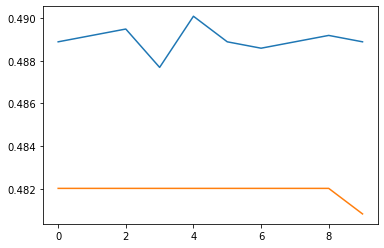

Wall time: 22.5 s


In [55]:
%%time
epochs = 10
learning_rate = 0.001
smoothing_constant = .01
train_acc = []
test_acc = []
loss_train=[]
loss_test=[]
los=0

for e in range(epochs):
    
    for i in range(30):
        
        #epsilons
        epsilons=sample_epsilons(layer_param_shapes)
        #sigmas=softplus(rhos)
        sigmas=transform_rhos(rhos)
        # obtain a sample from q(w|theta) by transforming the epsilons
        #aqui estanmos obteniendo las w's y b's desde las distribuciones N(mu,sig)
        layer_params=transform_gaussian_samples(mus, sigmas, epsilons)

        # forward-propagate the batch
        #esto es un fit de la red neuronal
        #print(np.append(1,x_train[i]).shape)
        output,H = net(np.append(1,x_train[i]), layer_params)
        #print(i,net(np.append(1,x_train[30]), layer_params)[0])
        # calculate the loss
        loss,lg = combined_loss(output, to_categorical(y_train)[i], layer_params, mus, sigmas, norm_prior, log_softmax_likelihood)

        variational_params = mus + rhos
        grad_l=[]
        for param in variational_params:
            grad_l.append(np.gradient(param))

            #grad_l[0][1]
        
        mus[0]=mus[0]-learning_rate*grad_l[0][1]
        mus[2]=mus[2]-learning_rate*grad_l[2][1]
        mus[4]=mus[4]-learning_rate*grad_l[4][1]
        
        rhos[0]=rhos[0]-learning_rate*grad_l[6][1]
        rhos[2]=rhos[2]-learning_rate*grad_l[8][1]
        rhos[4]=rhos[4]-learning_rate*grad_l[10][1]

        
        #print(lgs,loss,sigmas[0][0][0],rhos[0][0][0],gradsig1[0][0],dfs(layer_params[0],mus[0],sigmas[0],rhos[0])[0][0],(np.random.normal(size=(sigmas[0].shape))/(1+np.exp(-rhos[0])))[0][0],df1[0][0])
        # calculate moving loss for monitoring convergence
        curr_loss =np.mean(loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        #print(e,i,moving_loss)
        
        
    test_accuracy = evaluate_accuracy(agunos(x_test),y_test, net, mus)
    train_accuracy = evaluate_accuracy(agunos(x_train),y_train, net, mus)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, moving_loss, train_accuracy, test_accuracy))

    
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

In [49]:
layer_params[0].shape

(37, 400)

### **Bayes backprop  usando derivadas explícitas***

Epoch 0. Loss: 4029.756853157882, Train_acc 0.484093637454982, Test_acc 0.5059952038369304
Epoch 1. Loss: 4027.584622939529, Train_acc 0.4852941176470588, Test_acc 0.49640287769784175
Epoch 2. Loss: 4024.536188643219, Train_acc 0.4849939975990396, Test_acc 0.49280575539568344
Epoch 3. Loss: 4021.5130965592925, Train_acc 0.484093637454982, Test_acc 0.4856115107913669
Epoch 4. Loss: 4017.862850068211, Train_acc 0.484093637454982, Test_acc 0.47961630695443647
Epoch 5. Loss: 4014.127939254667, Train_acc 0.4849939975990396, Test_acc 0.49280575539568344
Epoch 6. Loss: 4010.092795897818, Train_acc 0.4837935174069628, Test_acc 0.4880095923261391
Epoch 7. Loss: 4005.969552620772, Train_acc 0.48559423769507803, Test_acc 0.49280575539568344
Epoch 8. Loss: 4001.7238180802165, Train_acc 0.4849939975990396, Test_acc 0.49760191846522783
Epoch 9. Loss: 3997.5066092078246, Train_acc 0.484093637454982, Test_acc 0.4856115107913669


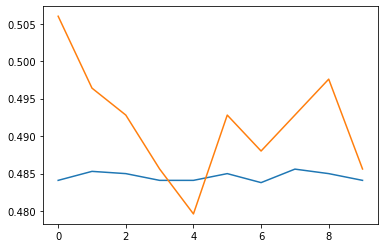

Wall time: 26.8 s


In [53]:
%%time
epochs = 10
learning_rate = 0.0001
smoothing_constant = .01
train_acc = []
test_acc = []
loss_train=[]
loss_test=[]
los=0

for e in range(epochs):
    
    for i in range(30):
        
        #epsilons
        epsilons=sample_epsilons(layer_param_shapes)
        #sigmas=softplus(rhos)
        sigmas=transform_rhos(rhos)
        # obtain a sample from q(w|theta) by transforming the epsilons
        #aqui estanmos obteniendo las w's y b's desde las distribuciones N(mu,sig)
        layer_params=transform_gaussian_samples(mus, sigmas, epsilons)

        # forward-propagate the batch
        #esto es un fit de la red neuronal
        #print(np.append(1,x_train[i]).shape)
        output,H = net(np.append(1,x_train[i]), layer_params)
        #print(i,net(np.append(1,x_train[30]), layer_params)[0])
        # calculate the loss
        loss,lg = combined_loss(output, to_categorical(y_train)[i], layer_params, mus, sigmas, norm_prior, log_softmax_likelihood)

        df1=dfw1(layer_params[0],mus[0],sigmas[0],np.append(1,x_train[i]).reshape(-1,1),to_categorical(y_train)[i],output.reshape(1,-1),layer_params[4][1:,:],layer_params[2][1:,:],H[0].reshape(-1,1),H[1].reshape(-1,1))
        df2=dfw2(layer_params[2],mus[2],sigmas[2],x_train[i],to_categorical(y_train).reshape(-1,1)[i],output.reshape(1,-1),H[0].reshape(-1,1),H[1].reshape(-1,1),layer_params[4])
 
        df3=dfw3(layer_params[4],mus[4],sigmas[4],x_train[i],to_categorical(y_train)[i].reshape(1,-1),output.reshape(1,-1),np.append(1,H[1]).reshape(1,-1))


        grad1=df1+dfmu(layer_params[0],mus[0],sigmas[0])
        grad2=df2+dfmu(layer_params[2],mus[2],sigmas[2])
        grad3=df3+dfmu(layer_params[4],mus[4],sigmas[4])


        gradsig1=df1*(np.random.normal(size=(sigmas[0].shape))/(1+np.exp(-rhos[0])))+dfs(layer_params[0],mus[0],sigmas[0],rhos[0])
        gradsig2=df2*(np.random.normal(size=(sigmas[2].shape))/(1+np.exp(-rhos[2])))+dfs(layer_params[2],mus[2],sigmas[2],rhos[2])
        gradsig3=df3*(np.random.normal(size=(sigmas[4].shape))/(1+np.exp(-rhos[4])))+dfs(layer_params[4],mus[4],sigmas[4],rhos[4])
        
        #print(e,i,output,H[0][0],H[1][0],df1[0][0],df2[0][0],df3[0][0],gradsig1[0][0],gradsig2[0][0],gradsig3[0][0],grad1[0][0],grad2[0][0],grad3[0][0])
        #if np.isnan(gradsig1[0][0]):
         #   break         
   # if np.isnan(gradsig1[0][0]):
       # break        
        #if np.isnan(df1[0][0]):
        #    aux=layer_params
         #   break
        mus[0]=mus[0]-learning_rate*grad1
        mus[2]=mus[2]-learning_rate*grad2
        mus[4]=mus[4]-learning_rate*grad3
        
        rhos[0]=rhos[0]-learning_rate*gradsig1
        rhos[2]=rhos[2]-learning_rate*gradsig2
        rhos[4]=rhos[4]-learning_rate*gradsig3

        
        #print(lgs,loss,sigmas[0][0][0],rhos[0][0][0],gradsig1[0][0],dfs(layer_params[0],mus[0],sigmas[0],rhos[0])[0][0],(np.random.normal(size=(sigmas[0].shape))/(1+np.exp(-rhos[0])))[0][0],df1[0][0])
        # calculate moving loss for monitoring convergence
        curr_loss =np.mean(loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        #print(e,i,moving_loss)
        
        
    test_accuracy = evaluate_accuracy(agunos(x_test),y_test, net, mus)
    train_accuracy = evaluate_accuracy(agunos(x_train),y_train, net, mus)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, moving_loss, train_accuracy, test_accuracy))

    
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

In [84]:
np.log(1+np.exp(5))

5.006715348489118